In [23]:
!apt -q install libomp-dev
!pip -q install faiss-gpu

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import report

In [2]:
df_path = 'data/match/base.csv'

In [3]:
if os.path.exists(df_path):
    df_base = pd.read_csv(df_path)
else:
    print('Something is wrong')

In [4]:
def primary_information(df):
    """Вывод общей информации о датасете"""
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [5]:
def pass_value_barh(df):
    """Вывод графика с количеством пропущенных значений"""
    try:
        ax = (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
        )
        ax.set_xlabel("Пропущенные значения, %", fontsize = 16, color = 'SteelBlue')
        ax.set_ylabel("Поле", fontsize = 16, color = 'SteelBlue')
        ax.set_title('Процент пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')
    except:
        print('Пропусков нет')

In [6]:
primary_information(df_base)

Размерность: (291813, 73)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291813 entries, 0 to 291812
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      291813 non-null  object 
 1   0       291813 non-null  float64
 2   1       291813 non-null  float64
 3   2       291813 non-null  float64
 4   3       291813 non-null  float64
 5   4       291813 non-null  float64
 6   5       291813 non-null  float64
 7   6       291813 non-null  float64
 8   7       291813 non-null  float64
 9   8       291813 non-null  float64
 10  9       291813 non-null  float64
 11  10      291813 non-null  float64
 12  11      291813 non-null  float64
 13  12      291813 non-null  float64
 14  13      291813 non-null  float64
 15  14      291813 non-null  float64
 16  15      291813 non-null  float64
 17  16      291813 non-null  float64
 18  17      291813 non-null  float64
 19  18      291813 non-null  float64
 20  19      291813 non-nul

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3,3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
4,422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


In [7]:
df_base[df_base.duplicated()]

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
278,1094627-base,-112.601420,14.659848,-31.078667,-145.97214,84.031340,-59.144753,-131.393856,67.658120,126.131430,...,-86.018850,-52.210587,-168.73766,-108.589639,69.227050,8.807985,66.059870,122.387955,-1068.782367,-48.616196
1787,2647540-base,-98.582016,9.115912,-29.625948,-136.95290,44.238705,-102.649760,-318.868736,7.009765,116.234230,...,-127.139560,63.189690,-150.48932,117.215222,69.286570,5.410611,23.796204,86.770676,-1123.990179,16.866371
2464,3844315-base,-104.571190,12.288874,-16.421646,-166.79399,73.941925,-82.725100,-246.932017,-99.579200,121.038730,...,-72.755370,19.747887,-142.14366,152.833979,68.376335,-47.232970,30.621094,129.282330,-1074.464888,-20.108221
3782,1520795-base,-83.634970,7.981893,-22.003824,-158.93774,59.521710,-59.888897,-558.056696,139.246960,129.025100,...,-90.098580,0.868702,-147.26216,96.330156,69.041810,-0.497185,15.658428,134.961260,-211.479213,-86.684654
3800,3138852-base,-35.410570,9.074678,-156.952180,-160.26584,94.668470,-66.925970,-588.494526,29.830553,126.189350,...,-59.115920,41.182217,-78.97825,147.116749,69.773020,126.415695,-2.616074,132.587390,-1074.464888,-34.392776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291788,3052339-base,-139.788700,5.525117,-119.803710,-122.39069,0.579369,-46.731760,30.016411,-6.410591,119.066200,...,-60.226395,61.184450,-244.52368,80.859387,63.391080,64.220350,125.958590,134.838010,-1074.464888,-184.838800
291791,942660-base,-54.192610,1.963953,-47.633320,-169.01770,185.310410,-40.038345,-162.468589,-15.676332,117.845245,...,-56.998344,82.324600,-174.00125,-40.896630,66.893360,86.412250,36.134567,117.257800,-1022.856752,54.473133
291795,2914227-base,-100.647650,2.627517,-39.566650,-166.96920,-18.270157,-70.352510,-346.522929,113.660805,126.578735,...,-119.028410,0.734730,-160.28346,73.212628,66.759900,17.164093,2.500526,122.247696,-1065.108429,-87.547300
291801,2721032-base,-78.839490,8.760185,-93.862470,-131.47957,136.534670,-51.641228,-535.970568,19.693506,122.942930,...,-38.524475,27.979868,-230.66537,36.412024,70.363520,71.575970,106.367690,120.243030,-1074.464888,-11.148373


In [8]:
def draw_boxplots(df, ncols, nrows, title):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 32))
    i = 0
    for column in df.columns:
        if column == 'Id':
            continue
        sns.boxplot(data = df, y=column, ax=axs[i % nrows][i // nrows])
        i += 1
        # axs[i][j].set_xlabel(labels[i].x)
        # axs[i][j].set_ylabel(labels[i].y)
    fig.suptitle(title, fontsize=30);

In [25]:
def draw_hists(df, ncols, nrows, title):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 32))
    i = 0
    for column in df.columns:
        if column == 'Id':
            continue
        df[column].hist(ax=axs[i % nrows][i // nrows])
        i += 1
    fig.suptitle(title, fontsize=30);

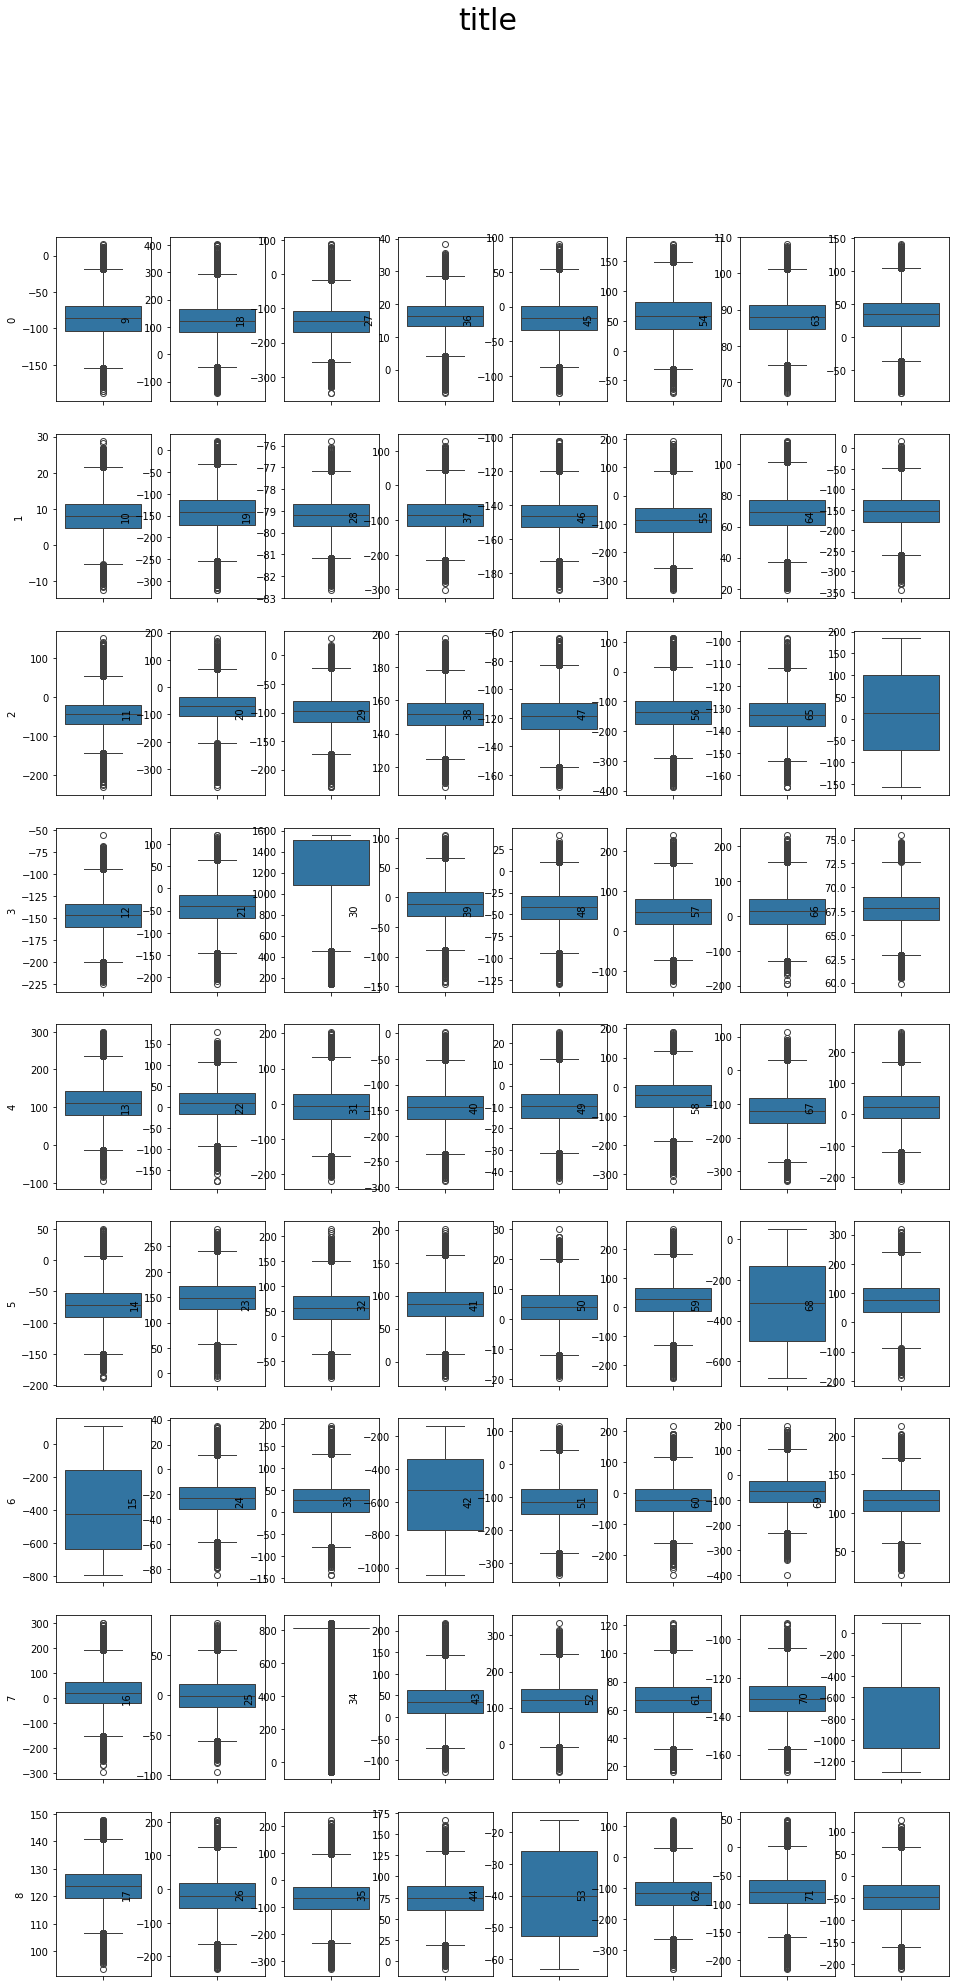

In [10]:
draw_boxplots(df_base, 8, 9, "title")

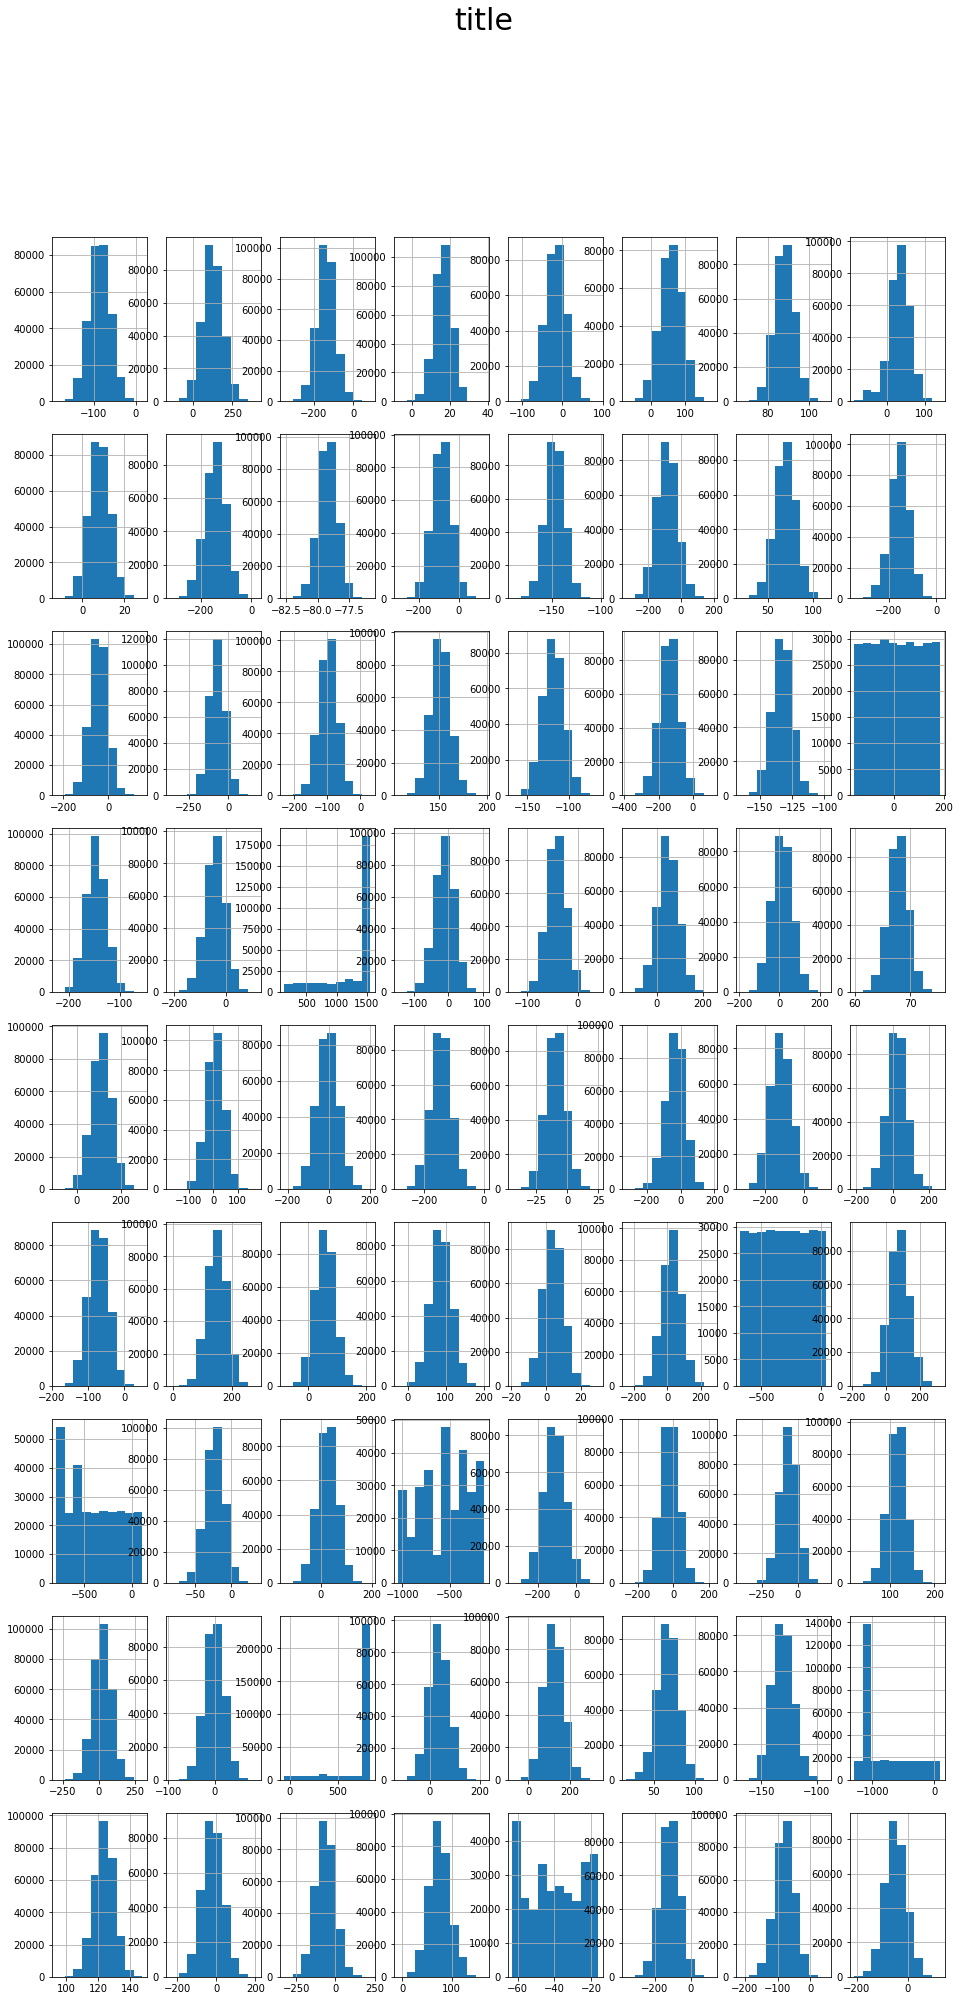

In [26]:
draw_hists(df_base, 8, 9, "title")

In [29]:
interval_cols = list(df_base.columns)
interval_cols.remove('Id')
cols = interval_cols[:10]
cols

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

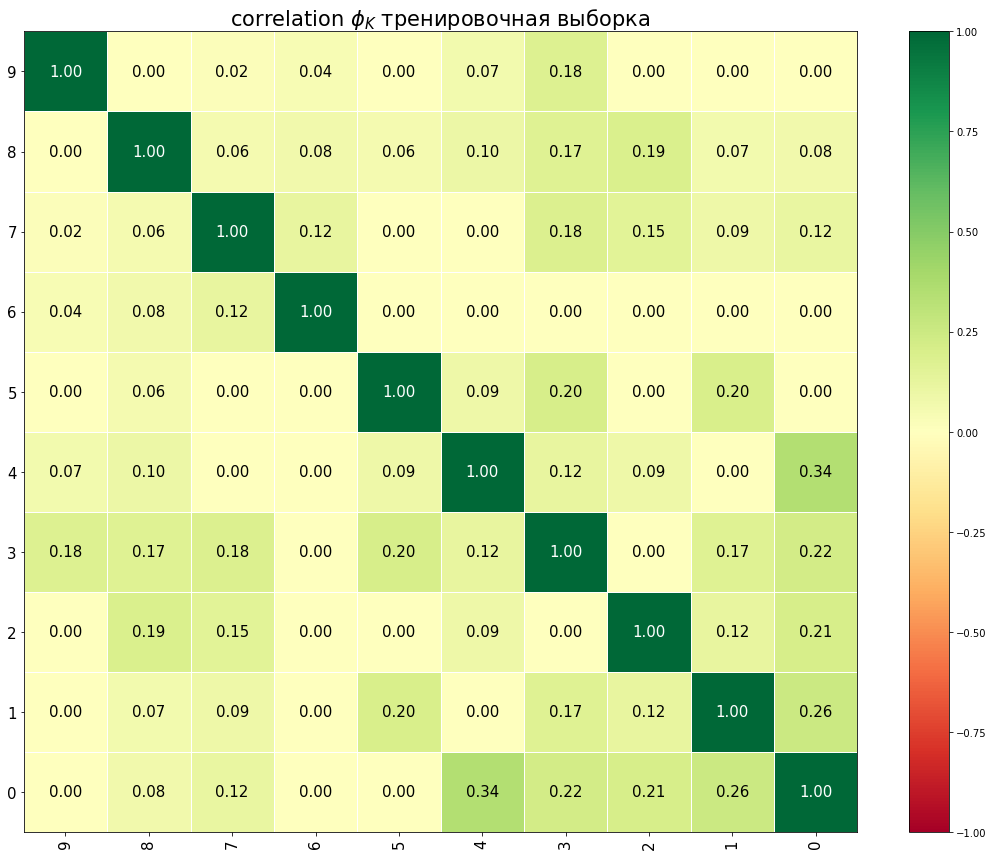

In [30]:
phik_overview = df_base[cols].sample(1000).phik_matrix(
    interval_cols=cols
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);